In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
__author__ = 'jcorrea'

# Data dependencies
import h5py
import pickle
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import os
# import ipdb

# E+Y: This might break things since I am appending the module's 
# PYTHONPATH from Edison on the system running the notebooks
import sys
sys.path.append("/project/projectdirs/nervana/jusk/experimental/site-packages/")


(-0.5, 223.5, 157.5, -0.5)

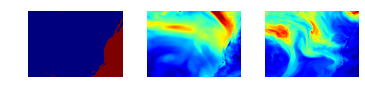

In [3]:
# Land-mask and TMQ data for AR/nAR

basepath = "/project/projectdirs/nervana/jusk/experimental/data"

fland = os.path.join(basepath, "landmask_imgs.pkl")
far = os.path.join(basepath, "atmosphericriver_TMQ.h5")

dland = np.asarray(pickle.load(open(fland, 'r'))['mask'])
darnar = h5py.File(far, 'r')

dar = np.asarray(darnar['AR'])
dnar = np.asarray(darnar['Non_AR'])

%matplotlib inline

# Land-mask, AR, nAR
f = plt.subplots()
plt.subplot(3, 3, 1)
plt.imshow(dland[0])
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(dar[0][0])
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(dnar[0][0])
plt.axis('off')

(-0.5, 223.5, 157.5, -0.5)

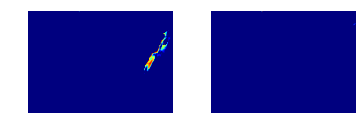

In [4]:
# TMQ thresholding
tmq_thr = 20
dar_i = np.multiply(dar, dland).clip(tmq_thr)
dnar_i = np.multiply(dnar, dland).clip(tmq_thr)

%matplotlib inline
# Thr LM.*AR/LM.*nAR
f = plt.subplots()

# Thresholded AR
plt.subplot(2, 2, 1)
plt.imshow(dar_i[0][0])
plt.axis('off')

# Thresholded nAR
plt.subplot(2, 2, 2)
plt.imshow(dnar_i[0][0])
plt.axis('off')

In [5]:
# TR/TE sizes for AR/nAR

tr_size_ar = 2000
tr_size_nar = 2000

te_size_ar = 468
te_size_nar = 1077

l_ar = np.ones(tr_size_ar + te_size_ar)
l_nar = np.zeros(tr_size_nar + te_size_nar)

dar = dar_i
dnar = dnar_i

s = range(len(dar))
d = range(len(dnar))
np.random.shuffle(s)
np.random.shuffle(d)

tr_ar = np.squeeze(dar[s][:][:][:tr_size_ar])
tr_nar = np.squeeze(dnar[d][:][:][:tr_size_nar])

te_ar = np.squeeze(dar[s][:][:][-te_size_ar:])
te_nar = np.squeeze(dnar[d][:][:][-te_size_nar:])

In [8]:
# Some data manupulation
Ftr_ar = np.asarray([normalize(tr_ar[i]).flatten() for i in range(len(tr_ar))])
Ftr_nar = np.asarray([normalize(tr_nar[i]).flatten() for i in range(len(tr_nar))])
Fte_ar = np.asarray([normalize(te_ar[i]).flatten() for i in range(len(te_ar))])
Fte_nar = np.asarray([normalize(te_nar[i]).flatten() for i in range(len(te_nar))])

d_tr = np.vstack(([Ftr_ar, Ftr_nar]))
d_te = np.vstack(([Fte_ar, Fte_nar]))

l_tr = np.vstack(([[1,0]] * tr_size_ar,
                [[0,1]] * tr_size_nar))

l_te = np.vstack(([[1,0]] * te_size_ar,
                [[0,1]] * te_size_nar))

# xx_size = 158
# yy_size = 224

In [12]:
# neon dependencies
import logging
import neon
import neon.backends

from neon.datasets.dataset import Dataset

from neon.backends import gen_backend
from neon.layers import FCLayer, DataLayer, CostLayer
from neon.models import MLP
from neon.transforms import RectLin, Logistic, CrossEntropy
from neon.experiments import FitPredictErrorExperiment
from neon.params import val_init
import os
import numpy as np

logging.basicConfig(level=20)
logger = logging.getLogger()

# neon model
class AR(Dataset):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
        self.data_train = self.data['data_train']
        self.data_test = self.data['data_test']
        self.labels_train = self.data['labels_train']
        self.labels_test = self.data['labels_test']
                
#     def initialize(self):
#         pass
    
    def load(self, backend=None, experiment=None):
        # Dataset.inputs
        
#         self.backend = None
        self.inputs = {'train': self.data_train,
                       'test': self.data_test,
                       'validation': None}

        self.targets = {'train': self.labels_train,
                        'test': self.labels_test,
                        'validation': None}
        
        self.format()
        
def create_model():
    
    layers = []

    layers.append(DataLayer(name = 'd0', nout=35392))

    layers.append(FCLayer(
            name = 'h0',
            nout=200,
            lrule_init={'lr_params': {'learning_rate': 0.01,
                'momentum_params': {'coef': 0.9, 'type': 'constant'}},
                'type': 'gradient_descent_momentum'},
            weight_init=val_init.UniformValGen(low=-0.1,high=0.1),
            activation=RectLin()
        )
    )

    layers.append(FCLayer(
            name = 'output',
            nout = 2,
            lrule_init={'lr_params': {'learning_rate': 0.01,
                'momentum_params': {'coef': 0.9, 'type': 'constant'}},
                'type': 'gradient_descent_momentum'},
            weight_init=val_init.UniformValGen(low=-0.1,high=0.1),
            activation = Logistic()
        )
    )

    layers.append(CostLayer(
            name = 'cost',
            ref_layer = layers[0],
            cost = CrossEntropy()
        )
    )
    model = MLP(num_epochs=10, batch_size=200, layers=layers)
    return model



In [ ]:
model = create_model()
backend = gen_backend()

dataset =  AR(data={'data_train':d_tr,
                    'data_test':d_te,
                    'labels_train':l_tr,
                    'labels_test':l_te})

experiment = FitPredictErrorExperiment(model=model, backend=backend, dataset=dataset)

experiment.run()